# Run This Notebook

<h3><a href="https://hub.openveda.cloud/hub/user-redirect/git-pull?repo=https://github.com/NASA-IMPACT/veda-docs&urlpath=lab/tree/veda-docs/user-guide/notebooks/stories/derechos.ipynb&branch=main">🚀 Launch in VEDA JupyterHub (requires access)</a></h3>

<h4> To obtain credentials to VEDA Hub, <a href = "https://docs.openveda.cloud/user-guide/scientific-computing/getting-access.html"> follow this link for more information.</a></h4>

<div class="alert alert-block" style="
     background-color: #f8d7da;
     color: #721c24;
     border-left: 4px solid #28a745;
  ">
Disclaimer: it is highly recommended to run a tutorial within NASA VEDA JupyterHub, which already includes functions for processing and visualizing data specific to VEDA stories. Running the tutorial outside of the VEDA JupyterHub may lead to errors, specifically related to EarthData authentication. Additionally, it is recommended to use the Pangeo workspace within the VEDA JupyterHub, since certain packages relevant to this tutorial are already installed. </div>

<h4> If you <strong>do not</strong> have a VEDA Jupyterhub Account you can launch this notebook on your local environment using MyBinder by clicking the icon below.</h4>
<br/>
<a href="https://binder.openveda.cloud/v2/gh/NASA-IMPACT/veda-docs/9c8cdbae92906fb7062b8a0c759dad90e223a4f9?urlpath=lab%2Ftree%2Fuser-guide%2Fnotebooks%2Fstories%2Fderechos.ipynb">
<img src="https://binder.openveda.cloud/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> </a>

## Example scripts to process and visualize information

In [1]:
# Load libraries
#!pip install -q earthaccess pandas xarray fsspec requests pystac_client

import earthaccess
from earthaccess import Auth, Store
from pystac_client import Client
import datetime
import pandas as pd
import xarray as xr
import fsspec
import requests
import json


import plotutils as putils

In [2]:
#For retrieving data already catalogued in VEDA STAC
STAC_API_URL="https://openveda.cloud/api/stac"
RASTER_API_URL = "https://openveda.cloud/api/raster"

# What is a Derecho?

A **derecho** is a long-lasting, fast-moving windstorm that is produced from a line of severe thunderstorms. For a storm to be called a derecho, there must be:

- A concentrated area of severe wind reports over 400 miles (650 km) in length and at least 60 miles (96 km) wide.
- Several wind gusts reported over 75 mph (120 km/h).
- Sustained winds of at least 58 mph (93 km/h). (SPC)

Unlike single thunderstorms, derechos form within mesoscale (i.e., mid-sized) convective systems (MCS)—large storm clusters that produce strong, long-lasting straight-line winds.

## Conditions that Help a Derecho Form Include:

- **Strong instability** (Convective Available Potential Energy (CAPE) over 2000–4000 J/kg): provides energy for strong updrafts and intense thunderstorms.  
- **High low-level moisture** (dewpoints of 65–75 °F): keeps storms going by supplying moisture.  
- **Strong mid- and upper-level winds** (wind shear over 40 knots): help organize storms and push them forward.  
- **A well-defined cold pool**: rain-cooled air at the surface strengthens the storm by increasing wind speeds at the front of the system.  


<div class="alert alert-block alert-warning">
<h1><strong>Example:</strong> Retrieve GLDAS data from EarthData portal</h1>
<h3>Global Land Data Assimilation System (GLDAS) data helps assess soil moisture levels before and after the storm, showing how pre-existing drought conditions contributed to dust transport and how heavy rainfall may have impacted runoff and flooding.</h3>
</div>


### Processing steps:
1.) Provide credentials for EarthAccess authentication<br />
2.) Select a start and end date for the data granules<br />
3.) Add <a href="https://search.earthdata.nasa.gov/search/granules?p=C1690022359-GES_DISC&pg[0][v]=f&pg[0][gsk]=-start_date&q=GLDAS_CLSM10_3H_2.1&tl=1347014600.484!5!!&lat=0.05719976537514171&long=-0.07464366545408296&zoom=3.0033333333333334"
        target="_blank" rel="noopener noreferrer"
         style="color: blue; text-decoration: none;">
      model name and version from EarthData portal
    </a><br />
4.) Add the prefix for the data within the bucket (e.g., remote sensing mission, reanalysis model, etc.)<br />
5.) Retrieve all files within the collection based on the start and end date. (If the same year is selected for start_date and end_date, then only the common year will be retrieved. Else all granules are retrived.<br />
6.) Filter all collected granules based on the start_ and end_date range.<br />
7.) Compute daily mean of hourly files<br />
8.) Plot variable based on coordinates selected<br />
9.) Create a .gif over the start_ and end_date range

In [3]:
# ── Authenticate ──────────────────────────────────────────────────────────────
auth = earthaccess.login()

store = Store(auth)

### Select dates and find Earthdata links

In [4]:
# ── Search by date ────────(requires >2GB RAM if more than 40 dates are selected)───────────────
start_date = datetime.datetime(2022, 4, 1)
end_date = datetime.datetime(2022, 5, 12)
date_array = pd.date_range(start=start_date, end=end_date, freq='D').to_pydatetime()

# ── Dataset ─────────────────────────────────────────────────────────────────────────────────────
short_name="GLDAS_NOAH025_3H"
version="2.1"
variable = 'SoilMoi0_10cm_inst' #Only select a single variable of interest

# get all granules
print('Retrieving data granules from Earthaccess') 
results = earthaccess.search_data(
   short_name=short_name,
   version=version,
   temporal=(start_date, end_date),
   cloud_hosted=True
)

# grab the S3 URLs
urls = [g["umm"]["RelatedUrls"][1]["URL"] for g in results]
print(f"Found {len(urls)} files")

# ── Open granules ───────────────────────────────────────────────────────────────────────────────
granules=earthaccess.open(results)
fs = earthaccess.get_s3_filesystem(results=results)   # auto‐picks the right DAAC & creds

fsspec_caching = {
    "cache_type": "mmap"
}
lat_range=slice(24, 50)
lon_range=slice(-125, -66)

def subset(ds):
    return ds[[variable]].sel(lat=lat_range, lon=lon_range)

ds = xr.open_mfdataset(
    [fs.open(url, **fsspec_caching) for url in urls],
    chunks="auto",
    concat_dim="time",
    combine="nested",
    parallel=True,
    data_vars="minimal",
    coords="minimal",
    compat="override",
    join="exact",
    preprocess=subset,
)

# ── Compute Daily Mean ───────────────────────────────────────────────────────────────────────────────
ds_resampled = ds.resample(time="1D").mean(dim='time').compute()
ds_resampled

Retrieving data granules from Earthaccess
Found 329 files


QUEUEING TASKS | :   0%|          | 0/329 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/329 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/329 [00:00<?, ?it/s]

<xarray.Dataset> Size: 4MB
Dimensions:             (time: 42, lat: 104, lon: 236)
Coordinates:
  * lat                 (lat) float32 416B 24.12 24.38 24.62 ... 49.62 49.88
  * lon                 (lon) float32 944B -124.9 -124.6 ... -66.38 -66.12
  * time                (time) datetime64[ns] 336B 2022-04-01 ... 2022-05-12
Data variables:
    SoilMoi0_10cm_inst  (time, lat, lon) float32 4MB nan nan nan ... nan nan nan
Attributes: (12/16)
    missing_value:          -9999.0
    tavg definition::       past 3-hour average
    acc definition::        past 3-hour accumulation
    inst definition::       instantaneous
    title:                  GLDAS2.1 LIS land surface model output
    institution:            NASA GSFC
    ...                     ...
    comment:                website: https://ldas.gsfc.nasa.gov/gldas, https:...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25

### Create interactive geospatial folium plot


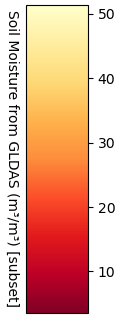
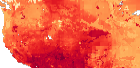

In [5]:
# Use the plot_folium_from_xarray function from plotutils
putils.plot_folium_from_xarray(dataset=ds_resampled['SoilMoi0_10cm_inst'],
                  day_select='2022-05-11',
                  bbox=[-130, 33, -90, 50],
                  var_name_for_title='Soil Moisture from GLDAS (m³/m³) [subset]',
                  matplot_ramp = 'YlOrRd_r',
                  zoom_level = 4.5,
                  flipud=False,
                  save_tif=False,
                  tif_filename=None,
                  crs = '4326',
                  opacity = 0.8)

### Create a gif over the date range

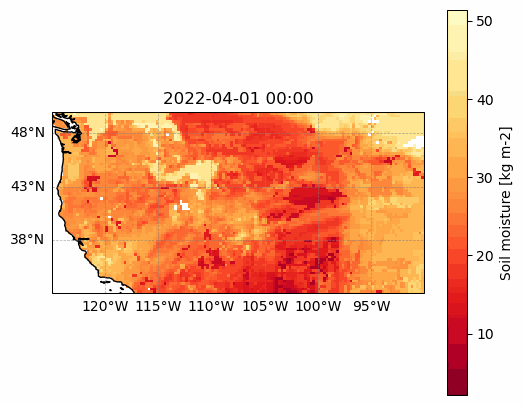

✅ Saved GIF → soil_matplotlib.gif


In [6]:
# Usage:
putils.matplotlib_gif(data=ds_resampled['SoilMoi0_10cm_inst'],
               bbox= [-130, 33, -90, 50],
               gif_savename= "soil_matplotlib.gif",
               duration=2,
               cmap="YlOrRd_r")

<div class="alert alert-block alert-warning">
<h2><strong>Example:</strong> Pull WLDAS soil moisture data from the VEDA STAC catalog and visualize.</h2>

The Western Land Data Assimilation System (WLDAS) is a regional instance of NASA’s Land Information System (LIS), developed at Goddard Space Flight Center for the western United States.  It integrates meteorological forcings (precipitation, radiation, temperature, humidity, wind, surface pressure) and satellite-derived parameters (vegetation class, soil texture, elevation) into the Noah-MP land surface model using data assimilation techniques.

Soil moisture critically controls the partitioning of net surface energy into latent (evapotranspiration) versus sensible (heating) fluxes. Wetter soils favor latent heat, stabilizing the boundary layer, whereas drier soils boost sensible heating, enhancing near-surface temperature and convective available potential energy (CAPE). These processes govern where and when thunderstorms can initiate and organize.
</div>


### Processing steps:
1.) Choose STAC catalog ID and date<br />
2.) Retrieve collection information and items from VEDA STAC catalog<br />
3.) Retrieve item statistics and tiling information<br />
4.) Plot data<br />

### Choose variable and retrieve json from VEDA STAC catalogue

In [7]:
#TODO: Change collection_ID and date
client_STAC = Client.open(STAC_API_URL)

collection_id = 'wldas-derecho-sm'
date = "2022-05-11"

results = client_STAC.search(collections=[collection_id], datetime=date)

# ── VEDA Collection Request ─────────────────────────────────────────────────────────────────────────────────────

items = list(results.items())
assert len(items) != 0, "No items found"
item = items[0]
collection = item.get_collection()

# grab the dashboard render block
dashboard_render = collection.extra_fields["renders"]["dashboard"]

assets = dashboard_render['assets'][0]
(vmin, vmax), = dashboard_render["rescale"]

collection


<CollectionClient id=wldas-derecho-sm>

### Retrieve tiling information

In [8]:
# ── VEDA Tile Request ─────────────────────────────────────────────────────────────────────────────────────
colormap_name = "hot"

# Build endpoint URL without worrying about trailing slashes
response = requests.get(
    f"{RASTER_API_URL.rstrip('/')}/collections/{collection_id}"
    f"/items/{item.id}/WebMercatorQuad/tilejson.json?"
    f"&assets={assets}"
    f"&color_formula=gamma+r+1.05&colormap_name={colormap_name}"
    f"&rescale={vmin},{vmax}",
)

response.raise_for_status()

tiles = response.json()
print(tiles)


{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://openveda.cloud/api/raster/collections/wldas-derecho-sm/items/WLDAScog_SM_2022-05-11/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=cog_default&color_formula=gamma+r+1.05&colormap_name=hot&rescale=0%2C0.4'], 'minzoom': 0, 'maxzoom': 24, 'bounds': [-179.1473680657398, 17.67439908061759, 179.7784301170628, 71.38922567703183], 'center': [0.3155310256614996, 44.53181237882471, 0]}


### Plot data

In [9]:
# Use the new plot_folium_from_VEDA_STAC function
m = putils.plot_folium_from_VEDA_STAC(
    tiles_url_template=tiles['tiles'][0],
    center_coords=[41.5, -110],
    zoom_level=5,
    rescale=(vmin,vmax),
    colormap_name=colormap_name,
    capitalize_cmap=False,  #to better match VEDA colors and matplotlib colors
    layer_name="WLDAS soil moisture",
    date=f'{date}T00:00:00Z',
    colorbar_caption="Soil Moisture (m3/m3)",
    attribution='VEDA WLDAS Soil Moisture',
    tile_name='WLDAS Soil Moisture Data',
    opacity=0.8,
    height =  "800px"
)

# Display the map
m

<div class="alert alert-block alert-warning">
<h2><strong>Example:</strong> Retrieve MERRA-2 hourly files for Aerosol Optical Thickness</h2>

Aerosol Optical Thickness (AOT), also called Aerosol Optical Depth (AOD), is a dimensionless measure of how much sunlight aerosols—tiny particles like dust, smoke or sea salt—scatter and absorb as it travels through a column of atmosphere. In practical terms, an AOT of 0.1 means only 10 % of the direct solar beam is extinguished by aerosols before reaching the surface.

The intense straight-line winds in derechos can uplift large quantities of soil and dust, dramatically increasing AOT downwind. Tracking AOT in near-real-time reveals the spatial extent and intensity of these airborne dust plumes.
</div>


### Processing steps:
1.) Select a start and end date for the data granules<br />
2.) Add <a href="https://search.earthdata.nasa.gov/search/granules/collection-details?p=C1276812830-GES_DISC&pg[0][v]=f&pg[0][gsk]=-start_date&q=merra%20aerosol&tl=1031468010.052!5!!"
        target="_blank" rel="noopener noreferrer"
         style="color: blue; text-decoration: none;">
      model name and version from EarthData portal
    </a><br />
3.) Add the prefix for the data within the bucket (e.g., remote sensing mission, reanalysis model, etc.)<br />
4.) Retrive all files within the collection based on the start and end date. (If the same year is selected for start_date and end_date, then only the common year will be retrieved. Else all granules are retrived.<br />
5.) Filter all collected granules based on the start_ and end_date range.<br />
6.) Plot variable based on coordinates selected<br />
7.) Create a .gif over the start_ and end_date range

### Select and filter

In [10]:
# ── Search by date ──────────────────────────────────────────────────────────────────────────────
start_date = datetime.datetime(2022, 5, 12)
end_date = datetime.datetime(2022, 5, 12)
date_array = pd.date_range(start=start_date, end=end_date, freq='D').to_pydatetime()

# ── Dataset ─────────────────────────────────────────────────────────────────────────────────────
short_name="M2T1NXAER"
version="5.12.4"
variable = 'TOTEXTTAU' #Total aerosol extinction optical thickness

# get all granules
print('Retrieving data granules from Earthaccess') 
results = earthaccess.search_data(
   short_name=short_name,
   version=version,
   temporal=(start_date, end_date),
   cloud_hosted=True
)

# grab the S3 URLs
urls = [g["umm"]["RelatedUrls"][1]["URL"] for g in results]
print(f"Found {len(urls)} files")

# ── Open granules ───────────────────────────────────────────────────────────────────────────────
granules=earthaccess.open(results)
fs = earthaccess.get_s3_filesystem(results=results)   # auto‐picks the right DAAC & creds

fsspec_caching = {
    "cache_type": "mmap"
}
lat_range=slice(24, 50)
lon_range=slice(-125, -66)

def subset(ds):
    return ds[[variable]].sel(lat=lat_range, lon=lon_range)

ds = xr.open_mfdataset(
    [fs.open(url, **fsspec_caching) for url in urls],
    chunks="auto",
    concat_dim="time",
    combine="nested",
    parallel=True,
    data_vars="minimal",
    coords="minimal",
    compat="override",
    join="exact",
    preprocess=subset,
)

ds

Retrieving data granules from Earthaccess
Found 1 files


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 485kB
Dimensions:    (time: 24, lat: 53, lon: 95)
Coordinates:
  * lon        (lon) float64 760B -125.0 -124.4 -123.8 ... -67.5 -66.88 -66.25
  * lat        (lat) float64 424B 24.0 24.5 25.0 25.5 ... 48.5 49.0 49.5 50.0
  * time       (time) datetime64[ns] 192B 2022-05-12T00:30:00 ... 2022-05-12T...
Data variables:
    TOTEXTTAU  (time, lat, lon) float32 483kB dask.array<chunksize=(13, 53, 95), meta=np.ndarray>
Attributes: (12/30)
    History:                           Original file generated: Sun May 22 22...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_aer_Nx.20220512.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/KLICLTZ8EM9D
    RangeBeginningDate:                2022-05-12
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2022-05-12
    RangeEndingTime:                   23:59:59.000000

## Open the MERRA file and plot by hour in a .gif for the selected variable AOT

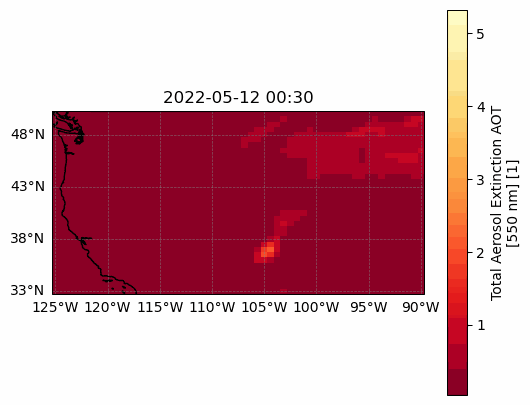

✅ Saved GIF → merra_aot.gif


In [11]:
# Use the matplotlib_gif function from plotutils
putils.matplotlib_gif(data=ds['TOTEXTTAU'],
               bbox= [-130, 33, -90, 50],
               gif_savename= "merra_aot.gif",
               duration=2,
               cmap="YlOrRd_r");

<div class="alert alert-block alert-warning">
<h2><strong>Example:</strong> Pull MODIS Aerosol Optical Depth data from the VEDA STAC catalog and visualize</h2>
</div>


In [12]:
collection_id = 'modis-derecho'
date = "2022-05-12"

results = client_STAC.search(collections=[collection_id], datetime=date)

# ── VEDA Collection Request ─────────────────────────────────────────────────────────────────────────────────────

items = list(results.items())
assert len(items) != 0, "No items found"
item = items[0]
collection = item.get_collection()

# grab the dashboard render block
dashboard_render = collection.extra_fields["renders"]["dashboard"]

assets = dashboard_render['assets'][0]
(vmin, vmax), = dashboard_render["rescale"]

collection


<CollectionClient id=modis-derecho>

In [13]:
# ── VEDA Tile Request ─────────────────────────────────────────────────────────────────────────────────────
colormap_name = "viridis"

# Build endpoint URL without worrying about trailing slashes
response = requests.get(
    f"{RASTER_API_URL.rstrip('/')}/collections/{collection_id}"
    f"/items/{item.id}/WebMercatorQuad/tilejson.json?"
    f"&assets={assets}"
    f"&color_formula=gamma+r+1.05&colormap_name={colormap_name}"
    f"&rescale={vmin},{vmax}",
)

response.raise_for_status()

tiles = response.json()
print(tiles)

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://openveda.cloud/api/raster/collections/modis-derecho/items/derecho_MODIS_AOD_2022-05-12/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=cog_default&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=0%2C0.2'], 'minzoom': 0, 'maxzoom': 24, 'bounds': [-104.9587947491025, 39.60418504240213, -87.8641172323396, 49.635984790222665], 'center': [-96.41145599072104, 44.62008491631239, 0]}


In [14]:
# Use the new plot_folium_from_VEDA_STAC function
m = putils.plot_folium_from_VEDA_STAC(
    tiles_url_template=tiles['tiles'][0],
    center_coords=[42.5, -96],
    zoom_level=7,
    rescale=(vmin,vmax),
    colormap_name=colormap_name,
    layer_name="MODIS AOD",
    date=f'{date}T00:00:00Z',
    colorbar_caption="Aerosol Optical Depth",
    attribution='VEDA MODIS AOD',
    tile_name='MODIS AOD',
    opacity=0.8,
    height =  "800px"
)

# Display the map
m

<div class="alert alert-block alert-warning">
<h2><strong>Example:</strong> Pull NCEI interpolated wind gusts data from the VEDA STAC catalog and visualize.</h2>
    
The NCEI Interpolated Wind Gusts product takes the discrete station‐reported peak wind gusts from the NCEI Storm Events Database—a standardized archive of severe‐weather observations dating back to 1950—and uses spatial interpolation to generate a continuous gridded field of maximum gust speeds across the derecho swath. 

By filling in the gaps between point measurements, it reveals the full geographic extent and intensity gradients of the derecho’s outflow winds, often uncovering zones of extreme gust (e.g., 70 mph +) that lie between and beyond individual station sites. 

</div>


In [15]:
collection_id = 'windgusts-derecho'
date = "2022-05-12"

results = client_STAC.search(collections=[collection_id], datetime=date)

# ── VEDA Collection Request ─────────────────────────────────────────────────────────────────────────────────────

items = list(results.items())
assert len(items) != 0, "No items found"
item = items[0]
collection = item.get_collection()

# grab the dashboard render block
dashboard_render = collection.extra_fields["renders"]["dashboard"]

assets = dashboard_render['assets'][0]
(vmin, vmax), = dashboard_render["rescale"]

collection


<CollectionClient id=windgusts-derecho>

In [16]:
# ── VEDA Tile Request ─────────────────────────────────────────────────────────────────────────────────────
colormap_name = "viridis"

# Build endpoint URL without worrying about trailing slashes
response = requests.get(
    f"{RASTER_API_URL.rstrip('/')}/collections/{collection_id}"
    f"/items/{item.id}/WebMercatorQuad/tilejson.json?"
    f"&assets={assets}"
    f"&color_formula=gamma+r+1.05&colormap_name={colormap_name}"
    f"&rescale={vmin},{vmax}",
)

response.raise_for_status()

tiles = response.json()
print(tiles)

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://openveda.cloud/api/raster/collections/windgusts-derecho/items/Windgusts_cog_2022-05-12/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=cog_default&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=75%2C100'], 'minzoom': 0, 'maxzoom': 24, 'bounds': [-104.98043829543191, 39.61453189361588, -87.85370728055949, 49.62204006079752], 'center': [-96.41707278799569, 44.618285977206696, 0]}


In [17]:
# Use the new plot_folium_from_VEDA_STAC function
m = putils.plot_folium_from_VEDA_STAC(
    tiles_url_template=tiles['tiles'][0],
    center_coords=[45, -97.7],
    zoom_level=6,
    rescale=(vmin,vmax),
    colormap_name=colormap_name,
    capitalize_cmap=False,  #to better match VEDA colors and matplotlib colors
    layer_name="Wind Gusts",
    date=f'{date}T00:00:00Z',
    colorbar_caption="Wind Gusts (mph)",
    attribution='VEDA Wind Gusts',
    tile_name='Wind Gusts',
    opacity=0.8,
    height =  "800px"
)

# Display the map
m

<div class="alert alert-block alert-warning">
<h2><strong>Example:</strong> Pull Black Marble Night Lights data from the VEDA STAC catalog and visualize.</h2>

During extreme windstorms such as derechos, sudden drops in nighttime brightness in the Black Marble imagery reveal where power infrastructure has failed and outages have occurred, while the re-illumination of areas over subsequent days tracks the pace and extent of electrical service restoration. This makes Black Marble a powerful, near-real-time proxy for assessing societal impacts and grid resilience in the storm’s wake.
</div>


In [18]:
collection_id = 'nightlights-derecho'
date = "2022-05-10"

results = client_STAC.search(collections=[collection_id], datetime=date)

# ── VEDA Collection Request ─────────────────────────────────────────────────────────────────────────────────────

items = list(results.items())
assert len(items) != 0, "No items found"
item = items[0]
collection = item.get_collection()

# grab the dashboard render block
dashboard_render = collection.extra_fields["renders"]["dashboard"]

assets = dashboard_render['assets'][0]
(vmin, vmax), = dashboard_render["rescale"]

collection


<CollectionClient id=nightlights-derecho>

In [19]:
# ── VEDA Tile Request ─────────────────────────────────────────────────────────────────────────────────────
colormap_name = "bwr"

# Build endpoint URL without worrying about trailing slashes
response = requests.get(
    f"{RASTER_API_URL.rstrip('/')}/collections/{collection_id}"
    f"/items/{item.id}/WebMercatorQuad/tilejson.json?"
    f"&assets={assets}"
    f"&color_formula=gamma+r+1.05&colormap_name={colormap_name}"
    f"&rescale={vmin},{vmax}",
)

response.raise_for_status()

tiles = response.json()
print(tiles)

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://openveda.cloud/api/raster/collections/nightlights-derecho/items/Nightlightscog_2022-05-10/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=cog_default&color_formula=gamma+r+1.05&colormap_name=bwr&rescale=-255%2C255'], 'minzoom': 0, 'maxzoom': 24, 'bounds': [-112.07926856247974, 39.47957304015183, -88.2545230530161, 50.52441131325872], 'center': [-100.16689580774792, 45.00199217670527, 0]}


In [20]:
# Use the new plot_folium_from_VEDA_STAC function
m = putils.plot_folium_from_VEDA_STAC(
    tiles_url_template=tiles['tiles'][0],
    center_coords=[45, -93],
    zoom_level=8,
    rescale=(vmin, vmax),
    colormap_name=colormap_name,
    capitalize_cmap=False,  #to better match VEDA colors and matplotlib colors
    layer_name="Black Marble Night Lights",
    date=f'{date}T00:00:00Z',
    colorbar_caption="Artificial Light",
    attribution='VEDA Black Marble Night Lights',
    tile_name='Black Marble Night Lights',
    opacity=0.8,
    height =  "800px"
)

print('Visualization of St. Paul, Minnesota where values approaching 255 indicate power outages.')
# Display the map
m

Visualization of St. Paul, Minnesota where values approaching 255 indicate power outages.


<div class="alert alert-block alert-warning">
<h2><strong>Example:</strong> Pull Global Precipitation Measurement data through the Common Metadata Repository (CMR) STAC API.</h2>

NASA's Global Precipitation Measurement Mission (GPM) uses satellites to measure Earth's rain and snowfall for the benefit of mankind. Launched by NASA and JAXA on Feb. 27th, 2014, GPM is an international mission that sets the standard for spaceborne precipitation measurements.
</div>


In [21]:
#Specific for May 05, 2022 (using titiler-cmr request)
date = '2022-05-12'
basetile_URL = "https://staging.openveda.cloud/api/titiler-cmr/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?"
tile_URL = f"datetime={date}T00%3A00%3A00.000Z%2F{date}T23%3A59%3A59.999Z&resampling=bilinear&variable=precipitation&colormap_name=gnbu&rescale=0%2C46&concept_id=C2723754864-GES_DISC&backend=xarray"
tilejson_url = f"{basetile_URL}{tile_URL}"

In [22]:

m = putils.plot_folium_from_VEDA_STAC(
    tiles_url_template=tilejson_url,
    layer_name="GPM Imerge Precipitation",
    colorbar_caption="mm/hr",
    date = "2022-05-12",
    colormap_name = "Blues",
    capitalize_cmap=False,  #to better match VEDA colors and matplotlib colors
    center_coords = [46.55,-96.94],
    zoom_level = 5,
    height =  "800px",
    rescale = (0, 46)

)

m

## The economic impact reached beyond the crop fields. Many grain silos, irrigation systems, and farm buildings were also damaged or destroyed, adding to the financial burden on farmers.  See image below to identify crop types across the Midwest and the Storm Prediction Center reports across the Midwest.

### Use the slider below to compare the USDA corn and soybean land cover for the year 2022 and all unfiltered storm reports collected by the Storm Prediction Center (SPC) on May 12, 2022. 

Image credit [USDA](https://www.nass.usda.gov/Research_and_Science/Cropland/sarsfaqs2.php) and [Storm Prediction Center](https://www.spc.noaa.gov/).

In [23]:
# Usage example:
img1_path = "images/derecho/Derecho-Crop.jpg"
img2_path = "images/derecho/Derecho-storm-reports.jpg"

putils.create_pausable_blend_slider(img1_path, img2_path, width=800)


<div class="alert alert-block alert-info">
<h2><strong>End of visualizations</strong>
</div>


<div class="alert alert-block alert-danger">
<h2><strong>Clean Up</strong>
</div>

Remove any **.gif** files that were created to save on storage space. Additionally, remove any **core** files that were created if the kernel crashed.

In [24]:
import os
import glob

# find all .gif files in the current directory
for gif_path in glob.glob("*.gif"):
    try:
        os.remove(gif_path)
        print(f"Removed {gif_path}")
    except OSError as e:
        print(f"Error removing {gif_path}: {e}")

# find all core files in the current directory
for core_path in glob.glob("core.*"):
    try:
        os.remove(core_path)
        print(f"Removed {core_path}")
    except OSError as e:
        print(f"Error removing {core_path}: {e}")


Removed soil_matplotlib.gif
Removed merra_aot.gif
Removed core.469
